In [1]:
# Warnigs
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [2]:
# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [12]:
# Rehusable functions

def grid_report(grid, X_test, y_true, name='Model'):

    y_pred = grid.best_estimator_.predict(X_test)
    r2 = r2_score(y_true, y_pred)

    print('='*60)
    print(f'------ {name} ------ \n')
    print('Best Score: {:0.4f}'.format(grid.best_score_))
    print(f'Best parameters: {grid.best_params_}')
    print('-'*60)
    print('Test')
    print('R2: {:0.4f}'.format(r2))

    plt.plot([y_true.min(), y_true.max()],
              [y_true.min(), y_true.max()],
              'k--', linewidth=2, c='salmon')

    plt.scatter(y_true, y_pred, c='skyblue',
                label='R2: {:0.4f}'.format(r2))
    plt.legend()
    plt.title(f'Permorfamce model: {name}', fontsize=15)
    plt.ylabel('Predicted [$W/m^2$]')
    plt.xlabel('True data [$W/m^2$]')

def performance_plot(y_true, y_pred, name, r2):

    plt.plot([y_true.min(), y_true.max()],
              [y_true.min(), y_true.max()],
              'k--', linewidth=2, c='salmon')

    plt.scatter(y_true, y_pred, c='skyblue',
                label='R2: {:0.4f}'.format(r2))
    plt.legend()
    plt.title(f'Permorfamce model: {name}', fontsize=12)
    plt.ylabel('Predicted [$W/m^2$]')
    plt.xlabel('True data [$W/m^2$]')
    plt.show()
    
def report_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    
    performance_plot(y_test, y_pred, name, r2)
    

In [4]:
df = pd.read_csv('../../data/ghi.csv')
y = df['GHI']
X = df.drop('GHI', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

### Stacking by mean


XRFRegressor:

The R2 score: 0.9179


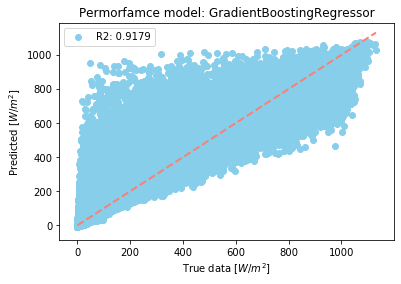

XRFRegressor:

The R2 score: 0.9262


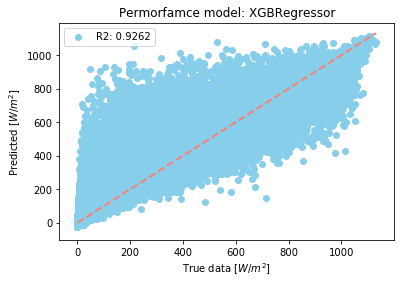

XRFRegressor:

The R2 score: 0.9278


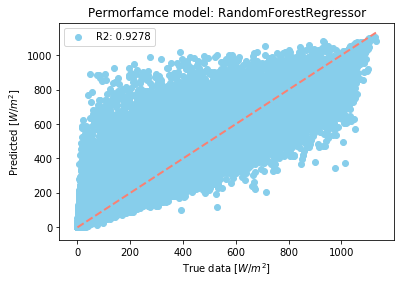

XRFRegressor:

The R2 score: 0.9125


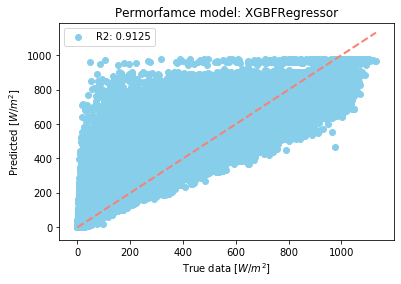

In [7]:
from sklearn.model_selection import cross_validate

# models
models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBFRegressor': XGBRFRegressor()
}

estimators_stack = {}

# Get the 5 estimators
for name, model in models.items():
    best = cross_validate(model, X_train, y_train,
                          cv=5,
                          scoring='r2',
                          return_estimator=True)
    
    estimators_stack[name] = best['estimator']

# Performance evaluation
for name, estimators in estimators_stack.items():
    predictions = []
    for estimator in estimators:
        y_pred = estimator.predict(X_test)
        predictions.append(y_pred)
   
    # Mean
    predictions = np.asarray(predictions)
    y_pred = np.mean(predictions, axis=0)
    
    # Performance
    r2 = r2_score(y_test, y_pred)
    print('='*60)
    print('XRFRegressor:\n')
    print('The R2 score: {:0.4f}'.format(r2))
    performance_plot(y_test, y_pred, name, r2)

## Stacking by Ridge

In [15]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ('RandomForest1', RandomForestRegressor(random_state=1)),
    ('RandomForest2', RandomForestRegressor(random_state=42)),
    ('RandomForest3', RandomForestRegressor(random_state=0)),
    ('RandomForest4', RandomForestRegressor(random_state=50)),
    ('RandomForest5', RandomForestRegressor(random_state=82)),
]

stacking_rfr = StackingRegressor(
    estimators=estimators, 
    final_estimator=RidgeCV(), 
    cv=5)

stacking_rfr.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('RandomForest1',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                             

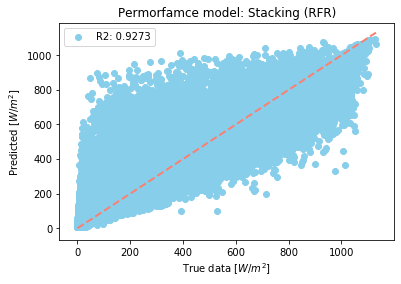

In [16]:
# Performance report
report_model(stacking_rfr, X_test, y_test, 'Stacking (RFR)')

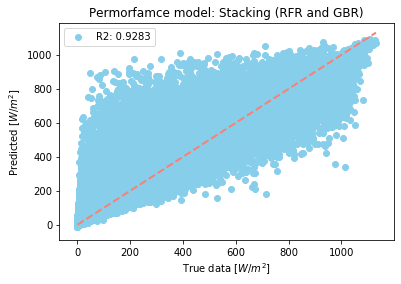

In [18]:
estimators = [
    ('RandomForest1', RandomForestRegressor(random_state=1)),
    ('RandomForest2', RandomForestRegressor(random_state=42)),
    ('XGBRegressor1', XGBRegressor(random_state=4)),
    ('XGBRegressor2', XGBRegressor(random_state=36)),
]

stacking_rfr_gbr = StackingRegressor(
    estimators=estimators, 
    final_estimator=RidgeCV(), 
    cv=5)

stacking_rfr_gbr.fit(X_train, y_train)

# Performance report
report_model(stacking_rfr_gbr, X_test, y_test, 'Stacking (RFR and GBR)')

### Conclusion
* The best is the combination of RFR and XGBReg